<a href="https://colab.research.google.com/github/finnayama/PRA3024/blob/main/Week2GW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 118.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 184.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 101.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 112.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 198.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 208.8 MB/s eta 0:00:00


In [2]:
#Import packages from example analysis
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries
from scipy import interpolate
import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d
from pycbc.filter import highpass
from pycbc import types 
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.waveform import get_td_waveform
import pycbc.psd

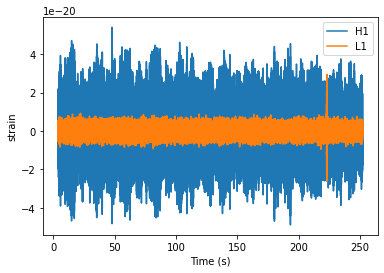

In [3]:
#
#
#
#TASK1 Matched Filter
#code from LoadDataFiles
d = np.load('/content/drive/MyDrive/Colab Notebooks/GW_noisedata-2.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
merger = Merger("GW170817")
strain, stilde = {}, {}
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()
#print (strain.delta_t)
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()

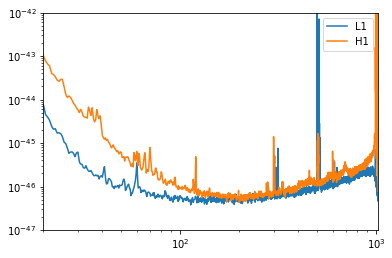

In [4]:
#Plot the Power Spectral density of the data as it will be used later for signal to noise ratio
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()

In [5]:
from pycbc.waveform import td_approximants, fd_approximants
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf
# List of td approximants thsqat are currently available
print(td_approximants())

--2023-03-15 21:47:39--  https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57824232 (55M)
Saving to: ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’

H-H1_LOSC_CLN_4_V1- 100%[===================>]  55.14M  45.6MB/s    in 1.2s    

2023-03-15 21:47:42 (45.6 MB/s) - ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ saved [57824232/57824232]

--2023-03-15 21:47:42--  https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62070438 (59M)
Saving to: ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’

L-L1_LOSC_CLN_4_V1- 100%[===================>]  59.19M  45.9MB/s    in 1.3s    

20

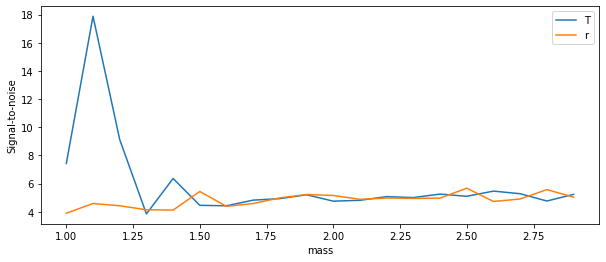

In [6]:
#Create Gravitational Wave waveform
#Code adjusted from the example
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

mass1 = numpy.arange(1, 3, 0.1) #mass range is from 1 to 3 solar masses
mass2 = mass1

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}

ifo = 'H1'
Snr_list = []
#Loop for first detector
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    m = mass1[i]
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)
  
    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
   
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)
  
    snr_H1 = snr.crop(4 + 4, 4)
    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

ifo = 'L1'
Snr_list = []
#Loop for second detector
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    m = mass1[i]
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))

    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)

    snr_H1 = snr.crop(4 + 4, 4)
    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

#Plot everything
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

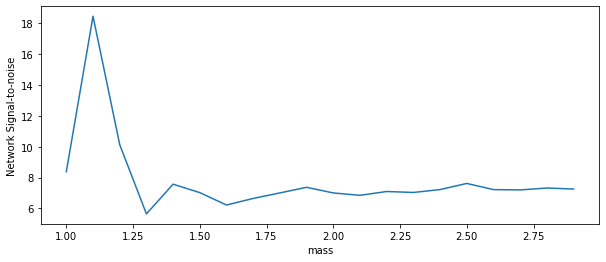

We found the best Mass1=Mass2 was 1.10 solar masses (detector frame)


In [7]:
nsnr = ((numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5)
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

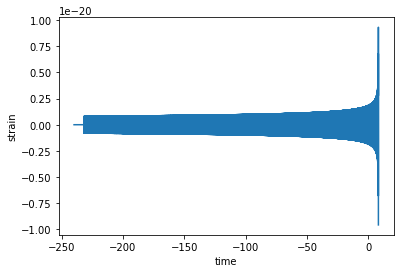

In [8]:
#Create a template of a waveform based on m=1.1 found previously
#Code from 'GravitationalWaveEventAnalysis' file uploaded on canvas

# We'll assume equal masses, which is within the posterior probability
# of GW150914. 
m = 1.1 # Solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                            mass1=m,
                            mass2=m,
                            delta_t=strain[ifo].delta_t,
                            f_lower=20)
# We will resize the vector to match our data
hp.resize(len(strain[ifo]))
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

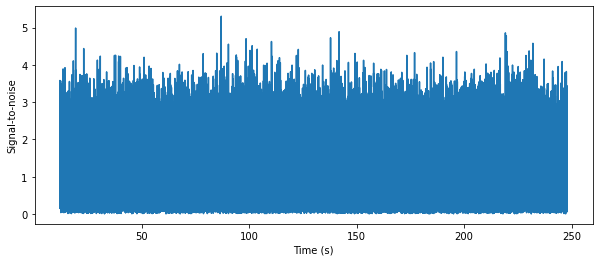

We found a signal at 87.046875s with SNR 5.302946179576333


In [9]:
#From example
from pycbc.filter import matched_filter
import numpy

ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))


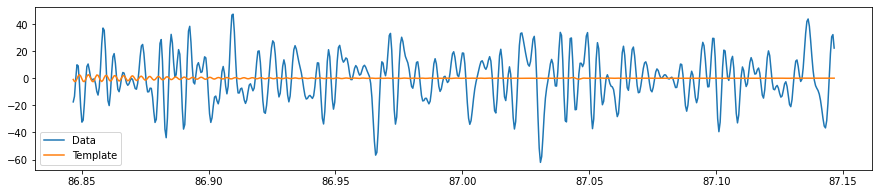

In [10]:
from pycbc.filter import sigma

#Shifting the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

#Scaling the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

#Scaling the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(time-0.2, time+0.1)
white_template = white_template.time_slice(time-0.2, time+0.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

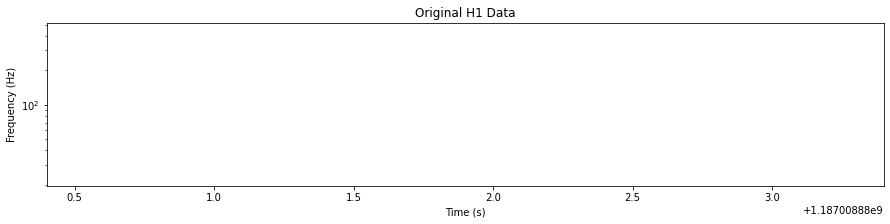

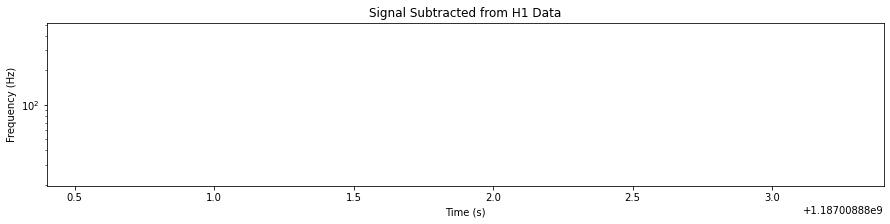

In [18]:
#from 'ExampleGravit...' adjusted code
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8,8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()
     

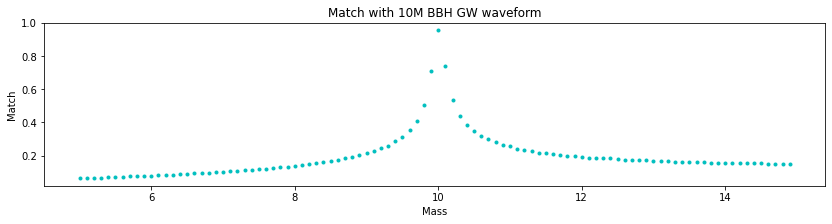

In [14]:
#TASK1 part 3
#Code from hints adjusted
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

f_low = 25
sample_rate = 4096
masses = np.arange(5,15,0.1)
matches = {}

for mass in masses:
  # Generate the two waveforms to compare
  hp, hc = get_td_waveform(approximant="EOBNRv2",
                          mass1=10,
                          mass2=10,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  sp, sc = get_td_waveform(approximant="TaylorT4",
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  # Resize the waveforms to the same length
  tlen = max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  # Generate the aLIGO ZDHP PSD
  delta_f = 1.0 / sp.duration
  flen = tlen//2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

  # subsequent calls are much faster.
  m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
  matches[mass]=m

#Plotting
pylab.figure(figsize=[14, 3])
pylab.title("Match with 10M BBH GW waveform")
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.plot(*zip(*matches.items()),'c.')
pylab.show()
     

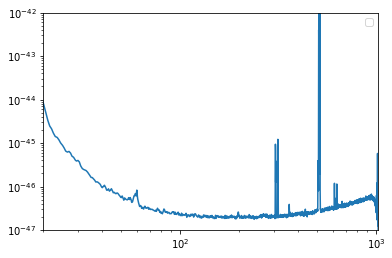

In [ ]:
#
#
#
#TASK2 Detector Noise
#Adjusted code from LoadDataFiles
d = np.load('/content/drive/MyDrive/Colab Notebooks/noise_ts_4096Hz.npy')
dt = d[:, 0]
data = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
merger = Merger("GW170817")
strain, stilde = {}, {}
strain = resample_to_delta_t(highpass(data, 15.0), 1.0/2048)

strain = strain.crop(4, 4)

stilde = strain.to_frequencyseries()

#Print the Power Spectral Density of new data file
psds = {}
delta_t = strain.delta_t
seg_len = int(2 / delta_t)
seg_stride = int(seg_len / 2)
psds  = pycbc.psd.welch(strain,
                        seg_len=seg_len,
                        seg_stride=seg_stride)
    
psds = interpolate(psds, stilde.delta_f)
pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)
pylab.legend()

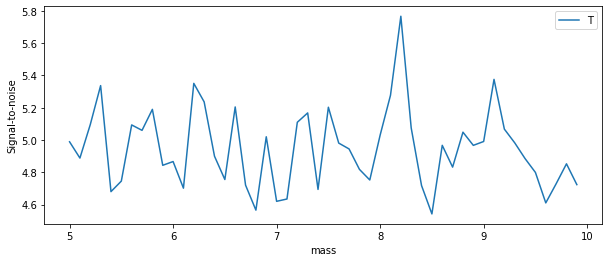

In [ ]:
#Create the signal to noise vs mass graph
#Use the same approach from Task 1 but change for just one line plot(remove [ifo])
#Because data [2] is only from one detector(Hanford)
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

mass1 = numpy.arange(5, 10, 0.1) #mass range is from 1 to 3 solar masses
mass2 = mass1

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}

Snr_list = []
#Loop for first detector
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    m = mass1[i]
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain.delta_t,
                     f_lower=15.0)
  
    # We will resize the vector to match our data
    hp.resize(len(strain))
   
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain,
                     psd=psds, low_frequency_cutoff=15.0)
  
    snr_H1 = snr.crop(4 + 4, 4)
    Snr_list.append(max(abs(snr_H1)))
snrs = Snr_list

#Plot everything
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs)
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

In [ ]:
print("From the graph you cannot see a peak greater than an 8 signal to noise ratio.")
print("This means you cannot claim detection of a GW.")

From the graph you cannot see a peak greater than an 8 signal to noise ratio.
This means you cannot claim detection of a GW.


In [15]:
#From assignment hints

import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd

# We do it this way so that we can whiten both the template and the data import​ pycbc.psd
white_data = (data.to_frequencyseries()/psds[ifo]**​0.5​).to_timeseries()

# The color of the noise matches a PSD which you provide
flow = 30.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate 32 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(32 / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)

pp.plot(ts.sample_times, ts)
pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.show()

SyntaxError: ignored